https://www.learndatasci.com/tutorials/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/

In [2]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

# Reading Data

- You can grab the data using the pandas *read_csv* method directly from GitHub. Alternatively, you can download it locally.

In [3]:
root = 'https://raw.githubusercontent.com/LearnDataSci/article-resources/master/Housing%20Price%20Index%20Regression'

housing_price_index = pd.read_csv(root + '/monthly-hpi.csv')
unemployment = pd.read_csv(root + '/unemployment-macro.csv')
federal_funds_rate = pd.read_csv(root + '/fed_funds.csv')
shiller = pd.read_csv(root + '/shiller.csv')
gross_domestic_product = pd.read_csv(root + '/gdp.csv')

In [6]:
housing_price_index.head()

,date,housing_price_index
0,2010-11-01,186.07
1,2010-12-01,183.27
2,2011-01-01,181.35
3,2011-02-01,179.66
4,2011-03-01,178.84


In [7]:
unemployment.head()

,date,total_unemployed,more_than_15_weeks,not_in_labor_searched_for_work,multi_jobs,leavers,losers
0,2010-11-01,16.9,8696,2531,6708,5.7,63.0
1,2010-12-01,16.6,8549,2609,6899,6.4,61.2
2,2011-01-01,16.2,8393,2800,6816,6.5,60.1
3,2011-02-01,16.0,8175,2730,6741,6.4,60.2
4,2011-03-01,15.9,8166,2434,6735,6.4,60.3


In [8]:
federal_funds_rate.head()

,date,federal_funds_rate
0,2010-11-01,0.19
1,2010-12-01,0.18
2,2011-01-01,0.17
3,2011-02-01,0.16
4,2011-03-01,0.14


In [9]:
shiller.head()

,date,sp500,consumer_price_index,long_interest_rate
0,2010-11-01,1198.89,218.80,2.76
1,2010-12-01,1241.53,219.18,3.29
2,2011-01-01,1282.62,220.22,3.39
3,2011-02-01,1321.12,221.31,3.58
4,2011-03-01,1304.49,223.47,3.41


In [10]:
gross_domestic_product.head()

,date,total_expenditures,labor_force_pr,producer_price_index,gross_domestic_product
0,2011-01-01,5766.7,64.2,192.7,14881.3
1,2011-04-01,5870.8,64.2,203.1,14989.6
2,2011-07-01,5802.6,64.0,204.6,15021.1
3,2011-10-01,5812.9,64.1,201.1,15190.3
4,2012-01-01,5765.7,63.7,200.7,15291.0


- Once we have the data, invoke pandas' *merge* method to join the data together in a single dataframe for analysis. Some data is reported monthly, others are reported quarterly. No worries. We merge the dataframes on a certain column so each row is in its logical place for measurement purposes. In this example, the best column to merge on is the *'date'* column.

In [5]:
# merge dataframes into single dataframe by date
df = (shiller.merge(housing_price_index, on='date')
                    .merge(unemployment, on='date')
                    .merge(federal_funds_rate, on='date')
                    .merge(gross_domestic_product, on='date'))

- Usually, the next step after gathering data would be exploratory analysis. Exploratory analysis is the part of the process where we analyze the variables (with plots and descriptive statistics) and figure out the best predictors of our dependent variable.


- For the sake of brevity, we'll skip the exploratory analysis. Keep in the back of your mind, though, that it's of utmost importance and that skipping it in the real world would preclude ever getting to the predictive section.


- We'll use **ordinary least squares (OLS)**, a basic yet powerful way to assess our model.

# Ordinary Least Squares Assumptions

*- OLS measures the accuracy of a linear regression model.*


*- OLS is built on assumptions which, if held, indicate the model may be the correct lens through which to interpret our data. If the assumptions don't hold, our model's conclusions lose their validity.*

Here are the OLS assumptions:


- **Linearity:** A linear relationship exists between the dependent and predictor variables. If no linear relationship exists, linear regression isn't the correct model to explain our data.

- **No multicollinearity:** Predictor variables are not collinear, i.e., they aren't highly correlated. If the predictors are highly correlated, try removing one or more of them. Since additional predictors are supplying redundant information, removing them shouldn't drastically reduce the Adj. R-squared (see below).

- **Zero conditional mean:** The average of the distances (or residuals) between the observations and the trend line is zero. Some will be positive, others negative, but they won't be biased toward a set of values.


- **Homoskedasticity:** The certainty (or uncertainty) of our dependent variable is equal across all values of a predictor variable; that is, there is no pattern in the residuals. In statistical jargon, the variance is constant.


- **No autocorrelation (serial correlation):** Autocorrelation is when a variable is correlated with itself across observations. For example, a stock price might be serially correlated if one day's stock price impacts the next day's stock price.

- Using statsmodels' *ols* function, we construct our model setting *housing_price_index* as a function of *total_unemployed*. We assume that an increase in the total number of unemployed people will have downward pressure on housing prices. Maybe we're wrong, but we have to start somewhere!


- The code below shows how to set up a simple linear regression model with *total_unemploymentas* our predictor variable.

In [11]:
# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
housing_model = ols("housing_price_index ~ total_unemployed", data=df).fit()

# summarize our model
housing_model_summary = housing_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(housing_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

To explain:

- **Adj. R-squared** indicates that 95% of housing prices can be explained by our predictor variable, total_unemployed.


- **The regression coefficient (coef)** represents the change in the dependent variable resulting from a one unit change in the predictor variable, all other variables being held constant. In our model, a one unit increase in total_unemployed reduces housing_price_index by 8.33. In line with our assumptions, an increase in unemployment appears to reduce housing prices.


- **The standard error** measures the accuracy of total_unemployed's coefficient by estimating the variation of the coefficient if the same test were run on a different sample of our population. Our standard error, 0.41, is low and therefore appears accurate.


- **The p-value** means the probability of an 8.33 decrease in housing_price_index due to a one unit increase in total_unemployed is 0%, assuming there is no relationship between the two variables. A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.


- **The confidence interval** is a range within which our coefficient is likely to fall. We can be 95% confident that total_unemployed's coefficient will be within our confidence interval, [-9.185, -7.480].

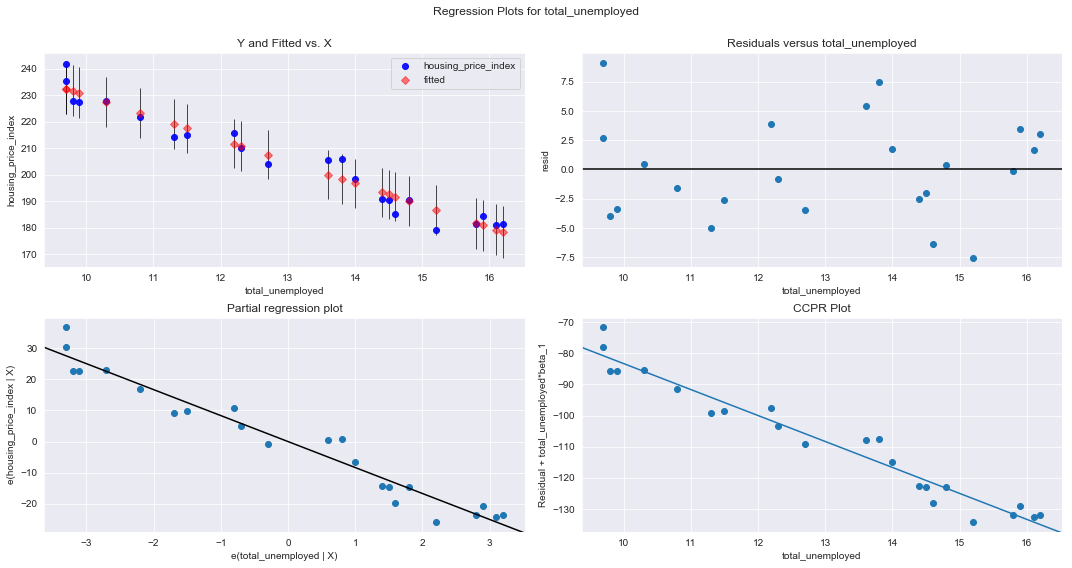

In [12]:
# This produces our four regression plots for total_unemployed

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(housing_model, "total_unemployed", fig=fig)

**Regression Plots**

*1 - The “Y and Fitted vs. X” graph plots the dependent variable against our predicted values with a confidence interval. The inverse relationship in our graph indicates that housing_price_index and total_unemployed are negatively correlated, i.e., when one variable increases the other decreases.*

*2 - The “Residuals versus total_unemployed” graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. Since there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.*
    
*3 - The “Partial regression plot” shows the relationship between housing_price_index and total_unemployed, taking in to account the impact of adding other independent variables on our existing total_unemployed coefficient. We'll see later how this same graph changes when we add more variables.*
    
*4 - The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot, but shows where our trend line would lie after adding the impact of adding our other independent variables on our existing total_unemployed coefficient. More on this plot here.*

    -  The next plot graphs our trend line (green), the observations (dots), and our confidence interval (red).